<a href="https://colab.research.google.com/github/Dharvi-k/Pytorch_Workflow/blob/main/Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyTorch Neural Network Classification**


# 1. Make classification data and get it ready

We'll use the make_circles() method from Scikit-Learn to generate two circles with different coloured dots.

In [263]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples=1000
x,y=make_circles(n_samples
                 ,noise=0.03, # a little bit of noise to the dots
                 random_state=42  #keep random state so we get the same values
                 )


let's print first 5 X and y values.

In [264]:
print(f"first 5 values of x:\n{x[:5]}")
print(f"first 5 values of y:\n{y[:5]}")

first 5 values of x:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 values of y:
[1 1 1 1 0]


In [265]:
# Make DataFrame of circle data
import pandas as pd
circles=pd.DataFrame({
    "x1":x[:,0],
    "x2":x[:,1],
    "label":y
})
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


How many values of each class are there?

In [266]:

# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


let's plot them

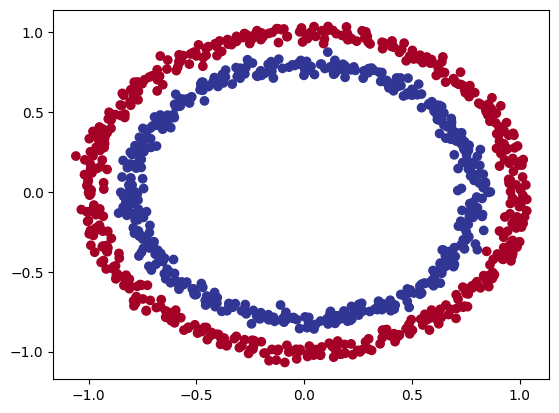

In [267]:
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

1.1 Input and output shapes

One of the most common errors in deep learning is shape error.
Ask yourself:

"What shapes are my inputs and what shapes are my outputs?"

In [268]:

# Check the shapes of our features and labels
x.shape,y.shape

((1000, 2), (1000,))

In [269]:
# View the first example of features and labels
x_sample=x[0]  # Take the first row (first data point) from X
y_sample=y[0] # Take the first label (answer) from y

print(f"Values for one sample of X: {x_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {x_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()



1.2 Turn data into tensors and create train and test splits

right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors

In [270]:
#Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
x=torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

# View the first five samples
x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [271]:
# Split data into train and test setsst_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

len(x_train), len(x_test), len(y_train), len(y_test)


(800, 200, 800, 200)

we've now got 800 training samples and 200 testing samples


# **2. Building a model**

1.Setting up device agnostic code (so our model can run on CPU or GPU if it's available).

2.constructing a model by subclassing nn.Module.

3.Defining a loss function and optimizer.
4.Creating a training loop

In [272]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

How about we create a model?


We'll want a model capable of handling our X data as inputs and producing something in the shape of our y data as outputs.


In other words, given X (features) we want our model to predict y (label).

This setup where you have features and labels is referred to as supervised learning. Because your data is telling your model what the outputs should be given a certain input

***Let's create a model class that:***

Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).

Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.

Defines a forward() method containing the forward pass computation of the model.

Instantiates the model class and sends it to the target device.

In [273]:

# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layer_2 =nn.Linear(in_features=5,out_features=1)
  # 3. Define a forward method containing the forward pass computation
  def forward(self,x):
    return self.layer_2(self.layer_1(x))  # Return the output of layer_2, a single feature, the same shape as y
# 4. Create an instance of the model and send it to target device
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

**we  can also do the same as above using nn.Sequential.**


**nn.Sequential performs a forward pass computation of the input data through the layers in the order they appear.**

In [274]:
# Replicate CircleModelV0 with nn.Sequential
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
              ).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.


So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

In [275]:

# Make predictions with the model(untrained model)
untrained_preds=model_0(x_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")




Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


the predictions don't look like they're in the same form or shape as the test labels

We've got a couple steps we can do to fix this, we'll see these later on.

**2.1 Setup loss function and optimizer**

In [276]:
# Create a loss function
loss_fn=nn.BCEWithLogitsLoss()   #BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.01)

Now let's also create an evaluation metric.

There are several evaluation metrics that can be used for classification problems but let's start out with accuracy.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.



In [277]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_pred,y_true):
  correct=torch.eq(y_pred,y_true).sum().item()
  acc=(correct/len(y_pred))*100
  return acc


#  3. Train model

**PyTorch training loop**

1.Frorward pass

2.Calculate the loss

3.zero graients

4.Perform back propagation on the loss

5.step the optimizer(gradient descent)


In [278]:

# View the frist 5 outputs of the forward pass on the test data
y_logits=model_0(x_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.


But what are they?


They're the output of our forward() method.


Which implements two layers of nn.Linear() which internally calls the following equation
:



y=x*weights + bias

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

In [279]:
# Use sigmoid on model logits
y_preds_prob=torch.sigmoid(y_logits)
y_preds_prob

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], grad_fn=<SigmoidBackward0>)

it seems like the outputs now have some kind of consistency (even though they're still random).


They're now in the form of prediction probabilities

 in other words, the values are now how much the model thinks the data point belongs to one class or another.


More specificially:

If y_pred_probs >= 0.5, y=1 (class 1)

If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [280]:
# Find the predicted labels (round the prediction probabilities)
y_preds=torch.round(y_preds_prob)

# In full
y_pred_labels=torch.round(torch.sigmoid(model_0(x_test.to(device)))[:5])

#check for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

#get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [281]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

**3.2 Building a training and testing loop**

In [282]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(x_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69460, Test acc: 57.50%
Epoch: 10 | Loss: 0.69768, Accuracy: 52.00% | Test loss: 0.69438, Test acc: 58.00%
Epoch: 20 | Loss: 0.69742, Accuracy: 52.00% | Test loss: 0.69418, Test acc: 57.50%
Epoch: 30 | Loss: 0.69717, Accuracy: 52.00% | Test loss: 0.69401, Test acc: 56.50%
Epoch: 40 | Loss: 0.69695, Accuracy: 51.62% | Test loss: 0.69385, Test acc: 56.50%
Epoch: 50 | Loss: 0.69675, Accuracy: 51.38% | Test loss: 0.69370, Test acc: 56.00%
Epoch: 60 | Loss: 0.69656, Accuracy: 51.38% | Test loss: 0.69357, Test acc: 56.00%
Epoch: 70 | Loss: 0.69638, Accuracy: 51.38% | Test loss: 0.69345, Test acc: 56.50%
Epoch: 80 | Loss: 0.69621, Accuracy: 51.25% | Test loss: 0.69334, Test acc: 56.50%
Epoch: 90 | Loss: 0.69606, Accuracy: 51.38% | Test loss: 0.69324, Test acc: 55.00%



# 4. Make predictions and evaluate the model

In [283]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


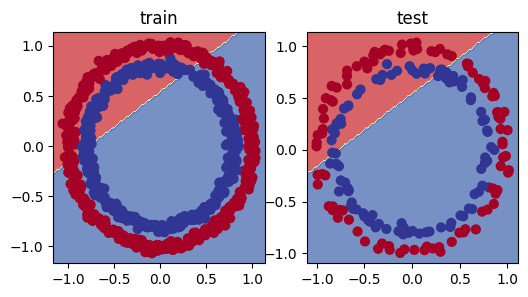

In [284]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0,x_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0,x_test,y_test)


Oh wow, it seems like we've found the cause of model's performance issue.


It's currently trying to split the red and blue dots using a straight line...


That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.



In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.


How could we improve this?


# 5. Improving a model (from a model perspective)

**Model improvement technique**

1. add more layers
2. add more hidden units
3. more epochs
4. changing the activation functions
5. changing the learning rate
6. changing the loss function
7. use transfer learning


We'll follow the same steps we did above but with a few changed hyperparameters.

In [285]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)  # extra layer
    self.layer_3=nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

Now we've got a model, we'll recreate a loss function and optimizer instance, using the same settings as before.

In [286]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn=nn.BCEWithLogitsLoss()  # Does not require sigmoid on input
optimizer=torch.optim.SGD(params=model_1. parameters(),
                          lr=0.1)

This time we'll train for longer (epochs=1000 vs epochs=100) and see if it improves our model.

In [287]:
torch.manual_seed(42)
epochs=1000 #Train for longer

# Put data to target device
x_train,y_train=x_train.to(device),y_train.to(device)
x_test,y_test=x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. forward pass
  y_logits=model_1(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)
   # 3. Optimizer zero grad
  optimizer.zero_grad()

   # 4. loss backwards
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits=model_1(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    # 2. Caculate loss/accuracy
    loss=loss_fn(test_logits,y_test)
    acc=accuracy_fn(y_true=y_test,
                    y_pred=test_pred)

# Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69261, Accuracy: 51.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 100 | Loss: 0.69379, Accuracy: 48.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 200 | Loss: 0.69437, Accuracy: 46.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 300 | Loss: 0.69458, Accuracy: 45.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 400 | Loss: 0.69465, Accuracy: 46.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 500 | Loss: 0.69467, Accuracy: 46.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 600 | Loss: 0.69468, Accuracy: 46.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 700 | Loss: 0.69468, Accuracy: 46.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 800 | Loss: 0.69468, Accuracy: 46.00% | Test loss: 0.69315, Test acc: 54.50%
Epoch: 900 | Loss: 0.69468, Accuracy: 46.00% | Test loss: 0.69315, Test acc: 54.50%


What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.


Let's visualize.

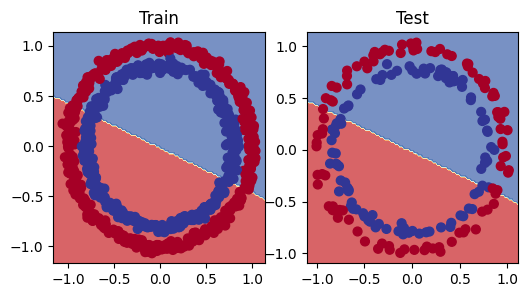

In [288]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,x_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,x_test,y_test)

**5.1 Preparing data to see if our model can model a straight line**

In [289]:
# create some data
weight=0.7
bias=0.3
start=0
end=1
step=0.01

# create data
x=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*x+bias

# check the data
print(len(x))
x[:5],y[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [290]:
x.shape,y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

**split the data into training and test sets.**

In [291]:

# Create train and test splits
train_split=int(len(x)*0.8) # 80% of data used for training set
x_train,y_train=x[:train_split],y[:train_split]
x_test,y_test=x[train_split:],y[train_split:]

# Check the lengths of each split
len(x_train),len(y_train),len(x_test),len(y_test)

(80, 80, 20, 20)

**let's plot the data with plot_predictions() functions we created in previus notebook and downloaded above with helper_functions()**


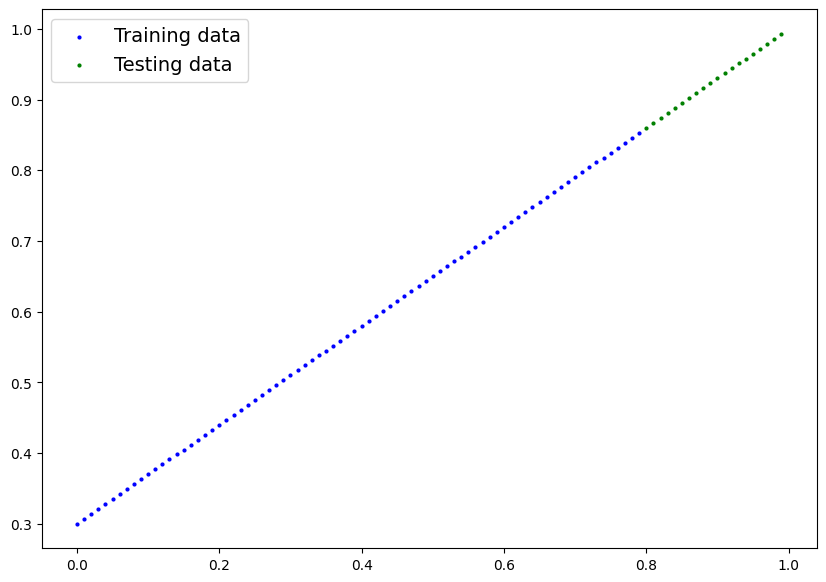

In [292]:
plot_predictions(train_data=x_train,
                 train_labels=y_train,
                 test_data=x_test,
                 test_labels=y_test
                 );


**5.2 Adjusting model_1 to fit a straight line**

Now we've got some data, let's recreate model_1 but with a loss function suited to our regression data.

In [293]:
# Same architecture as model_1 (but using nn.Sequential)
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [294]:
# Loss and optimizer
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),
                          lr=0.01)

Now let's train the model using the regular training loop steps for epochs=1000 (just like model_1).

In [295]:
# Train the model
torch.manual_seed(42)

# set the number of epochs
epochs=1000

# put the data to the target device
x_train,y_train=x_train.to(device),y_train.to(device)
x_test,y_test=x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  ### Training
  # 1. Forward pass
  model_2.train()
  y_pred=model_2(x_train)

  # 2. calculate the loss
  loss=loss_fn(y_pred,y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss baclwards
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_2.eval()
  test_pred=model_2(x_test)
  test_loss=loss_fn(test_pred,y_test)
 # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")



Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360


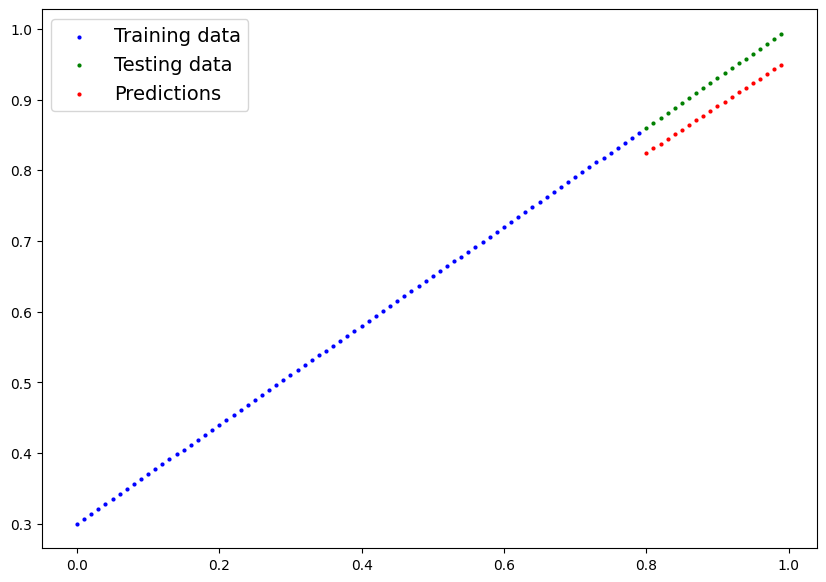

In [296]:
# turn on evalutaon mode
model_2.eval()
# make predictions
with torch.inference_mode():
  y_preds=model_2(x_test)
# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
plot_predictions(train_data=x_train.cpu(),
                train_labels=y_train.cpu(),
                 test_data=x_test.cpu(),
                 test_labels=y_test.cpu(),
                 predictions=y_preds.cpu())


In [297]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7474],
                      [ 0.8386],
                      [-0.2685],
                      [ 0.9277],
                      [-0.2253],
                      [ 0.2219],
                      [-0.5157],
                      [ 0.5984],
                      [ 0.8952],
                      [-0.7398]])),
             ('0.bias',
              tensor([ 0.8181,  0.1893,  0.6798,  0.1390,  0.4719, -0.1165,  0.7276,  0.1469,
                      -0.4521,  0.2444])),
             ('1.weight',
              tensor([[-6.8272e-02,  4.0207e-03, -9.4606e-02,  2.5110e-01, -2.2979e-01,
                       -1.4690e-01, -6.2611e-02, -1.6088e-01,  3.5127e-02, -3.2492e-01],
                      [ 3.0631e-01, -2.5446e-01,  2.4940e-01,  6.7609e-02, -1.0098e-01,
                        1.9585e-01,  5.0876e-02,  2.6490e-01,  4.2846e-02, -1.0855e-01],
                      [ 8.2267e-03, -1.2545e-01,  9.8334e-02,  2.4267e-01,  1.6198e-01,
            

# 6. The missing piece: non-linearity
We've seen our model can draw straight (linear) lines, thanks to its linear layers.


But how about we give it the capacity to draw non-straight (non-linear) lines?

How?

Let's find out.

**6.1 Recreating non-linear data (red and blue circles)**

First, let's recreate the data to start off fresh. We'll use the same setup as before.

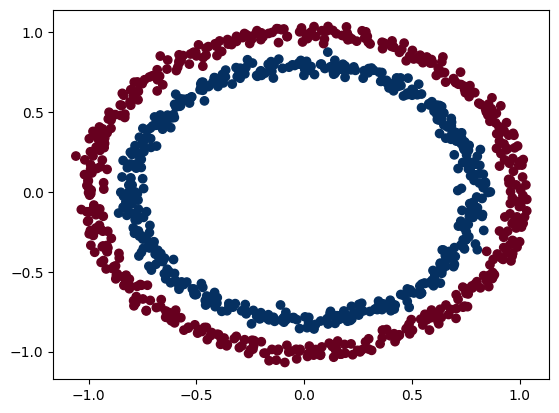

In [298]:
# Make and plot the data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples=1000
x,y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42)
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.RdBu)


 Now let's split it into training and test sets using 80% of the data for training and 20% for testing.

In [299]:
# Convert to tensors and split into training and testing sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
x=torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x,
                                               y,
                                               test_size=0.2,
                                               random_state=42)
x_train[:5],y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# 6.2 Building a model with non-linearity

In [300]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
    self.relu=nn.ReLU() # <- add in ReLU activation function

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3=CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [316]:
# set up loss and optmizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_3.parameters(),
                          lr=0.01)

# 6.3 Training a model with non-linearity

In [330]:
# fit the model
torch.manual_seed(42)
epochs=3000

# put all the data on target device
x_train,y_train=x_train.to(device),y_train.to(device)
x_test,y_test=x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_3.train()
  # 1. Forward pass
  y_logits=model_3(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  # 2. calculate the loss
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optmizer step()
  optimizer.step()


  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    # calculate loss and accuracy
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)


 # Print out what's happening
    if epoch % 100 == 0 or epoch==epochs-1:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.22092, Accuracy: 99.50% | Test Loss: 0.27112, Test Accuracy: 97.50%
Epoch: 100 | Loss: 0.21223, Accuracy: 99.50% | Test Loss: 0.26283, Test Accuracy: 97.50%
Epoch: 200 | Loss: 0.20404, Accuracy: 99.50% | Test Loss: 0.25485, Test Accuracy: 97.50%
Epoch: 300 | Loss: 0.19621, Accuracy: 99.50% | Test Loss: 0.24706, Test Accuracy: 97.50%
Epoch: 400 | Loss: 0.18877, Accuracy: 99.50% | Test Loss: 0.23943, Test Accuracy: 97.50%
Epoch: 500 | Loss: 0.18173, Accuracy: 99.50% | Test Loss: 0.23208, Test Accuracy: 97.50%
Epoch: 600 | Loss: 0.17507, Accuracy: 99.50% | Test Loss: 0.22505, Test Accuracy: 97.50%
Epoch: 700 | Loss: 0.16871, Accuracy: 99.50% | Test Loss: 0.21843, Test Accuracy: 97.50%
Epoch: 800 | Loss: 0.16267, Accuracy: 99.50% | Test Loss: 0.21199, Test Accuracy: 97.50%
Epoch: 900 | Loss: 0.15696, Accuracy: 99.50% | Test Loss: 0.20581, Test Accuracy: 98.00%
Epoch: 1000 | Loss: 0.15151, Accuracy: 99.62% | Test Loss: 0.19989, Test Accuracy: 98.50%
Epoch: 1100 | Loss: 0.

**6.4 Evaluating a model trained with non-linear activation functions**

let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [331]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(x_test))).squeeze()
y_preds[:10],y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

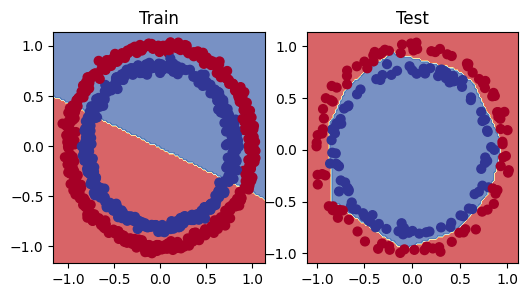

In [332]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,x_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,x_test,y_test)

after incresing number of epochs from 1000 to 3000 the accuracy went up to 99.88%.

